# Sample Canon Analysis

In [190]:
%load_ext autoreload
%autoreload 2
import os
from pathlib import Path

print(Path().cwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/davidspector/Home/Stanford/QuantUS Projects


In [191]:
os.chdir(Path().cwd().parent)

In [192]:
print(Path().cwd())

/Users/davidspector/Home/Stanford


## Select Image & Phantom and Parse

In [193]:
from pyquantus.parse.canon import findPreset, canonIqParser

In [194]:
# Inputs
imagePath = '/Users/davidspector/Home/Stanford/QuantUS Projects/Sample Data/Canon IQ/Sample Patient 001/Preset_2/image.bin'
phantomPath = '/Users/davidspector/Home/Stanford/QuantUS Projects/Sample Data/Canon IQ/Phantom data/Preset_2/phantom2.bin'

In [195]:
imPreset = findPreset(imagePath)
phantomPreset = findPreset(phantomPath)
assert imPreset == phantomPreset

In [196]:
imgDataStruct, imgInfoStruct, refDataStruct, refInfoStuct = canonIqParser(imagePath, phantomPath)

/Users/davidspector/Home/Stanford/QuantUS Projects/PyQuantUS/pyquantus/parse/canon.py:94: RuntimeWarning: divide by zero encountered in log10
  bmode = 20*np.log10(abs(iq))


## ROI Selection (from GUI)

In [197]:
import pickle

pkl_name = '/Users/davidspector/Home/Stanford/QuantUS Projects/Sample Data/Canon IQ/Sample Patient 001/Preset_2/roi.pkl'

with open(pkl_name, "rb") as f:
    roi_info = pickle.load(f)

In [198]:
assert roi_info["Image Name"] == Path(imagePath).name
assert roi_info["Phantom Name"] == Path(phantomPath).name

In [199]:
scSplineX = roi_info["Spline X"]
scSplineY = roi_info["Spline Y"]

## Analysis Config (from GUI)

In [200]:
from pyquantus.utc import AnalysisConfig

analysisConfigPath = '/Users/davidspector/Home/Stanford/QuantUS Projects/Sample Data/Canon IQ/Sample Patient 001/Preset_2/analysisConfig.pkl'

with open(analysisConfigPath, 'rb') as f:
    configPkl = pickle.load(f)
    
config = configPkl['Config']

# config = AnalysisConfig()

# config.transducerFreqBand = [0, 8000000] # [min, max] (Hz)
# config.analysisFreqBand = [3000000, 5000000] # [lower, upper] (Hz)
# config.samplingFrequency = 53330000 # Hz
# config.axWinSize = 50 # axial length per window (mm)
# config.latWinSize = 90 # lateral length per window (mm)
# config.windowThresh = 0.5 # % of window area required to be considered in ROI
# config.axialOverlap = 0 # % of window overlap in axial direction
# config.lateralOverlap = 0 # % of window overlap in lateral direction
# config.centerFrequency = 4000000 # Hz

## UTC Analysis

In [201]:
from pyquantus.utc import UtcAnalysis, UltrasoundImage

In [202]:
ultrasoundImage = UltrasoundImage()
ultrasoundImage.axialResRf = imgInfoStruct.depth / imgDataStruct.rf.shape[0]
ultrasoundImage.lateralResRf = ultrasoundImage.axialResRf * (
    imgDataStruct.rf.shape[0]/imgDataStruct.rf.shape[1]
) # placeholder
ultrasoundImage.bmode = imgDataStruct.bMode
ultrasoundImage.phantomRf = refDataStruct.rf
ultrasoundImage.rf = imgDataStruct.rf
ultrasoundImage.scBmode = imgDataStruct.scBmode
ultrasoundImage.xmap = imgDataStruct.scBmodeStruct.xmap
ultrasoundImage.ymap = imgDataStruct.scBmodeStruct.ymap

In [203]:
utcAnalysis = UtcAnalysis()
utcAnalysis.ultrasoundImage = ultrasoundImage
utcAnalysis.config = config
utcAnalysis.initAnalysisConfig()
utcAnalysis.scSplineX = scSplineX
utcAnalysis.scSplineY = scSplineY

In [204]:
utcAnalysis.refAttenuation = 0.5 # placeholder for attenuation coefficient at center freq (dB/cm/MHz)
utcAnalysis.refBackScatterCoef = 10e-3 # placeholder for backscatter coefficient at center freq (cm^-1 sr^-1)

In [205]:
utcAnalysis.splineToPreSc()
utcAnalysis.generateRoiWindows()
utcAnalysis.computeUtcWindows();

<string>:29: RuntimeWarning: overflow encountered in exp


In [214]:
utcAnalysis.roiWindows[0].results.__dict__.keys()

dict_keys(['nps', 'ps', 'rPs', 'f', 'mbf', 'ss', 'si'])

In [ ]:
import numpy as np

mbfArr = [window.results.mbf for window in utcAnalysis.roiWindows]
ssArr = [window.results.ss for window in utcAnalysis.roiWindows]
siArr = [window.results.si for window in utcAnalysis.roiWindows]

print("Average Midband Fit:", np.mean(mbfArr), "dB")
print("Average Spectral Slope:", np.mean(ssArr), "dB/MHz")
print("Average Spectral Intercept:", np.mean(siArr), "dB")
print("Attenuation Coefficient:", utcAnalysis.attenuationCoef, "dB/cm/MHz")
print("Backscatter Coefficient:", utcAnalysis.backScatterCoef, "1/cm-sr")
print("w Nakagami Parameter:", utcAnalysis.nakagamiParams[0])
print("u Nakagami Parameter:", utcAnalysis.nakagamiParams[1])
print("Effective Scatterer Diameter:", utcAnalysis.effectiveScattererDiameter, "µm") 
print("Effective Scatterer Concentration:", utcAnalysis.effectiveScattererConcentration, "dB/mm^3")

AttributeError: 'SpectralResults' object has no attribute 'attCoef'

# Visualizations

In [207]:
import matplotlib.pyplot as plt
from pyquantus.parse.objects import ScConfig
from pyquantus.utc import UtcData

In [208]:
scConfig = ScConfig()
scConfig.width = imgInfoStruct.width1
scConfig.tilt = imgInfoStruct.tilt1
scConfig.startDepth = imgInfoStruct.startDepth1
scConfig.endDepth = imgInfoStruct.endDepth1

In [209]:
utcData = UtcData()
utcData.utcAnalysis = utcAnalysis
utcData.scConfig = scConfig

In [210]:
utcData.convertImagesToRGB()

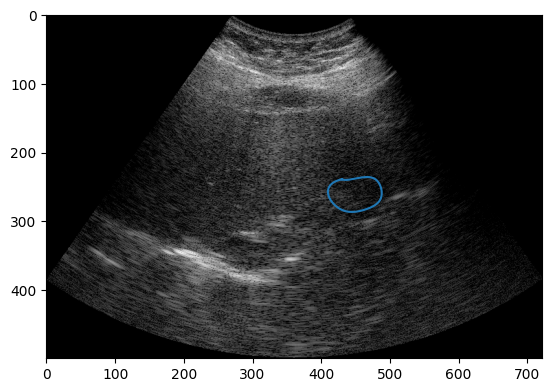

In [211]:
plt.imshow(utcData.scBmode)
plt.plot(scSplineX, scSplineY);

In [212]:
utcData.drawCmaps()
utcData.scanConvertCmaps()

AttributeError: 'SpectralResults' object has no attribute 'attCoef'

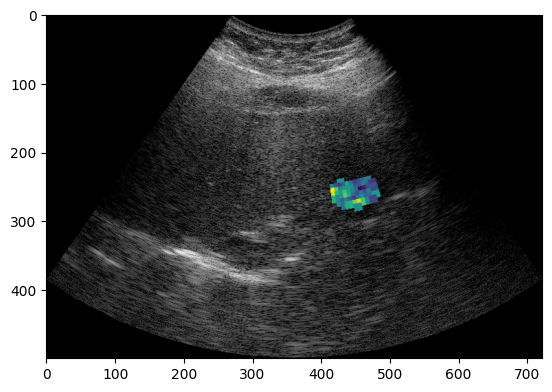

In [ ]:
plt.imshow(utcData.scMbfIm)

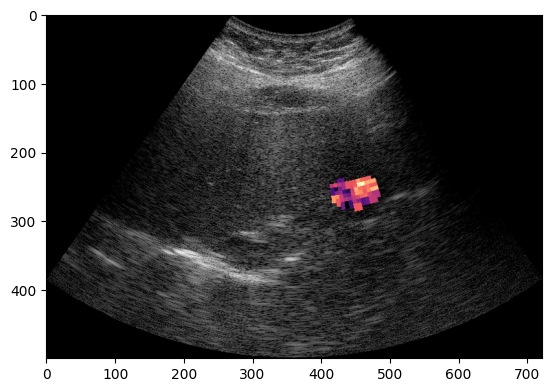

In [ ]:
plt.imshow(utcData.scSsIm)

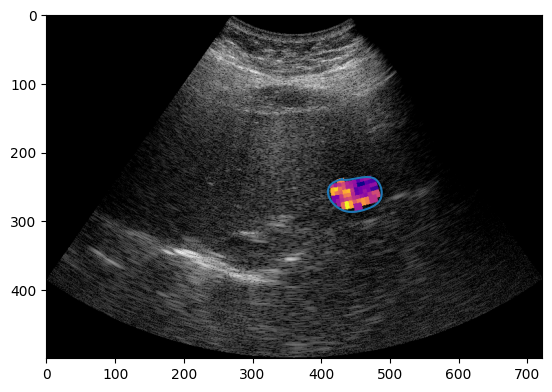

In [ ]:
plt.imshow(utcData.scSiIm)
plt.plot(utcData.splineX, utcData.splineY)

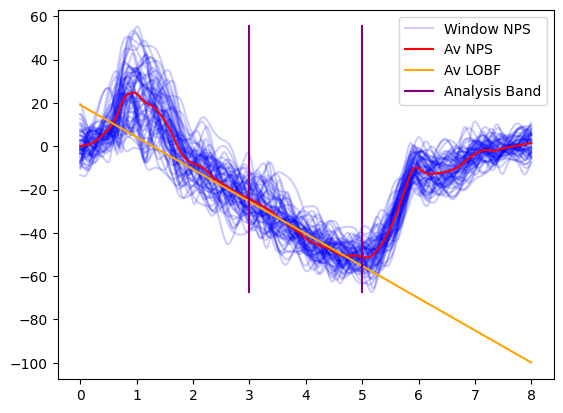

In [ ]:
utcData.plotPsData()